SimCLR study on Cifar10 data. 

Network: ResNet18 

Batch size: 256

Optimizer: SGD

Loss: NT-Xent loss

lr:  0.3

Pre-Training data: 10000 images (1000 image per class)

Trained for 300 epochs

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
from torch.optim import lr_scheduler
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
import matplotlib.pyplot as plt
#tqdm
from tqdm import tqdm

In [3]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")


In [4]:
index = loaded_data['index']
images1 = loaded_data['images']
labels1 = loaded_data['labels']
#print shape of tensors
images1=images1
images1 = images1 / 255
    # mean normalize
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
print(images1.shape)
print(labels1.shape)

torch.Size([10025, 3, 224, 224])
torch.Size([10025])


### Augmentaion on pre-training data

In [5]:
class Augment_train(object):
  def __init__(self,size):
    s = 0.5 # jitter strength
    size = 224
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    
    self.train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.8), 
        transforms.RandomGrayscale(p=0.2),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
  
  def __call__(self,x):
    transform = self.train_transforms

    xi = transform(x)
    xj = transform(x)
    return xi, xj

In [6]:
aumention = Augment_train(224)
augmented_images1,augmented_images2 = aumention(images1)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Prepare the Train loader

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

print(augmented_images1.shape)
print(augmented_images2.shape)
class CustomDataset(Dataset):
    def __init__(self, images1, images2):
        self.images1 = images1
        self.images2 = images2

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        return self.images1[idx], self.images2[idx]

custom_dataset = CustomDataset(augmented_images1, augmented_images2)
print(len(custom_dataset))
trainloader = DataLoader(custom_dataset, batch_size=256, shuffle=True, num_workers=8)


torch.Size([10025, 3, 224, 224])
torch.Size([10025, 3, 224, 224])
10025


In [8]:
data_loader_size = len(trainloader)
print("Data loader size:", data_loader_size)


Data loader size: 40


In [9]:
# import matplotlib.pyplot as plt

# # Get the first batch of images from the trainloader
# for i, (batch_images1, batch_images2) in enumerate(trainloader):
#     if i == 0:
#         break

# # Plot the images
# fig, axes = plt.subplots(2, 6, figsize=(10, 5))
# for i in range(6):
#     # Plot images from batch_images1
#     image1 = (batch_images1[i] - batch_images1[i].min()) / (batch_images1[i].max() - batch_images1[i].min())
#     axes[0, i].imshow(image1.permute(1, 2, 0))
#     axes[0, i].axis('off')

#     # Plot images from batch_images2
#     image2 = (batch_images2[i] - batch_images2[i].min()) / (batch_images2[i].max() - batch_images2[i].min())
#     axes[1, i].imshow(image2.permute(1, 2, 0))
#     axes[1, i].axis('off')

# plt.show()


### SimCLR  specific Loss function Cosine Similarity

In [10]:
class NTXent_L(nn.Module):
  def __init__(self,batch_size,temperature=0.5):
      super().__init__()
      self.batch_size=batch_size
      self.temperature = temperature
      
  def cosine_sim(self, output1,output2): #output1, output2 as 2 augmented versions of image;
    o_con= torch.cat([output1,output2], dim=0)
    return F.cosine_similarity(o_con.unsqueeze(1), o_con.unsqueeze(0), dim=2)
  def forward(self, z_i, z_j):

    batch_size= z_i.shape[0]

    sim_m = self.cosine_sim(z_i,z_j)

    sim_ij = torch.diag(sim_m,batch_size)
    sim_ji = torch.diag(sim_m, -batch_size)
   
    sim_con= torch.cat([sim_ij, sim_ji],dim=0)
    pos= torch.exp(sim_con/self.temperature)
    mask = (~torch.eye(batch_size *2 ,batch_size*2, dtype=bool)).float()
    neg= mask.to(device) *torch.exp(sim_m/self.temperature)
    loss = torch.sum(-torch.log(pos/torch.sum(neg, dim=1))) / (2*self.batch_size)
    
    return loss

In [11]:
criterion = NTXent_L(batch_size=256, temperature = 0.5)
criterion = criterion.to(device)

### SimCLR Model

In [13]:
base_encoder= torchvision.models.resnet50(pretrained=True)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
    
class SimCLR_model(nn.Module):

    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.linear=nn.Linear(n_features, n_features)

        self.base_encoder.fc = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
       
        return h_i, h_j, z_i, z_j
    
projection_dim=224
n_features= base_encoder.fc.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
net= net.to(device)
batch_size = 512
lr = 0.001
start_epoch=0
max_epoch=300
# optimizer= torch.optim.Adam(net.parameters(), lr)
optimizer= torch.optim.SGD(net.parameters(), lr)

### Base encoder = ResNet18

### Train the Pre-text task

In [17]:
# net

In [18]:
net.base_encoder.linear.weight


Parameter containing:
tensor([[-0.0036, -0.0102,  0.0140,  ..., -0.0171, -0.0219, -0.0013],
        [-0.0060, -0.0112, -0.0041,  ..., -0.0202,  0.0179,  0.0023],
        [ 0.0139, -0.0012, -0.0211,  ..., -0.0211,  0.0185, -0.0153],
        ...,
        [ 0.0093, -0.0010, -0.0122,  ..., -0.0011, -0.0207,  0.0220],
        [ 0.0091, -0.0197, -0.0172,  ..., -0.0219,  0.0085,  0.0173],
        [-0.0113,  0.0015, -0.0095,  ..., -0.0105,  0.0218,  0.0073]],
       device='cuda:0', requires_grad=True)

In [19]:
train_losses = []
def train(epoch):
    net.train()
    s = 0
    tot_loss = 0
    total = 0
    batch_idx = 0
    i = 0
    for batch_idx, (images) in enumerate(trainloader):
        images[0], images[1] = images[0].to(device), images[1].to(device)
        optimizer.zero_grad()

        h_i, h_j, z_i, z_j = net(images[0], images[1])
        loss = criterion(z_i, z_j)

        loss.backward()

        optimizer.step()

        tot_loss += loss.item()

    print("epoch=", epoch)
    print("epoch loss=", tot_loss)
    train_losses.append(tot_loss)

    if epoch % 25 == 0:
        modelstate_save_name = 'modelstate_bs_restart_r_bk.pt'
        path_modelstate = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{modelstate_save_name}"
        torch.save(net.state_dict(), path_modelstate)

        parameters_end = {
            'net': net.state_dict(),
            'epoch': epoch,
            'loss': tot_loss
        }
        paramsend_save_name = 'paramsend_bs_restart_r_bk.pt'
        path_paramsend = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{paramsend_save_name}"
        torch.save(parameters_end, path_paramsend)

# Assuming 'device' is defined appropriately, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in tqdm(range(start_epoch, start_epoch + 301)):
    train(epoch)


  0%|          | 0/301 [00:00<?, ?it/s]

epoch= 0
epoch loss= 215.36666405200958


  1%|          | 2/301 [00:59<2:27:35, 29.62s/it]

epoch= 1
epoch loss= 211.4250196814537


  1%|          | 3/301 [01:26<2:21:22, 28.47s/it]

epoch= 2
epoch loss= 207.89679288864136


  1%|▏         | 4/301 [01:53<2:18:11, 27.92s/it]

epoch= 3
epoch loss= 204.89127123355865


  2%|▏         | 5/301 [02:21<2:16:38, 27.70s/it]

epoch= 4
epoch loss= 202.36529755592346


  2%|▏         | 6/301 [02:48<2:16:10, 27.70s/it]

epoch= 5
epoch loss= 200.35878640413284


  2%|▏         | 7/301 [03:16<2:15:56, 27.74s/it]

epoch= 6
epoch loss= 198.628786444664


  3%|▎         | 8/301 [03:44<2:15:39, 27.78s/it]

epoch= 7
epoch loss= 197.30099213123322


  3%|▎         | 9/301 [04:12<2:15:36, 27.86s/it]

epoch= 8
epoch loss= 196.06668728590012


  3%|▎         | 10/301 [04:39<2:13:43, 27.57s/it]

epoch= 9
epoch loss= 195.09949362277985


  4%|▎         | 11/301 [05:06<2:12:52, 27.49s/it]

epoch= 10
epoch loss= 194.2397817671299


  4%|▍         | 12/301 [05:34<2:12:30, 27.51s/it]

epoch= 11
epoch loss= 193.51375290751457


  4%|▍         | 13/301 [06:01<2:11:50, 27.47s/it]

epoch= 12
epoch loss= 192.8197922706604


  5%|▍         | 14/301 [06:28<2:11:07, 27.41s/it]

epoch= 13
epoch loss= 192.24334833025932


  5%|▍         | 15/301 [06:56<2:10:26, 27.37s/it]

epoch= 14
epoch loss= 191.73461747169495


  5%|▌         | 16/301 [07:24<2:11:31, 27.69s/it]

epoch= 15
epoch loss= 191.19057190418243


  6%|▌         | 17/301 [07:51<2:10:15, 27.52s/it]

epoch= 16
epoch loss= 190.74363619089127


  6%|▌         | 18/301 [08:19<2:09:29, 27.46s/it]

epoch= 17
epoch loss= 190.31996223330498


  6%|▋         | 19/301 [08:46<2:08:35, 27.36s/it]

epoch= 18
epoch loss= 189.94958800077438


  7%|▋         | 20/301 [09:13<2:08:22, 27.41s/it]

epoch= 19
epoch loss= 189.61512181162834


  7%|▋         | 21/301 [09:41<2:07:42, 27.37s/it]

epoch= 20
epoch loss= 189.23701813817024


  7%|▋         | 22/301 [10:08<2:07:26, 27.41s/it]

epoch= 21
epoch loss= 188.9546646475792


  8%|▊         | 23/301 [10:35<2:06:54, 27.39s/it]

epoch= 22
epoch loss= 188.65928030014038


  8%|▊         | 24/301 [11:03<2:06:35, 27.42s/it]

epoch= 23
epoch loss= 188.37972682714462


  8%|▊         | 25/301 [11:30<2:05:41, 27.32s/it]

epoch= 24
epoch loss= 188.1047091782093
epoch= 25
epoch loss= 187.85088244080544


  9%|▉         | 27/301 [12:25<2:05:12, 27.42s/it]

epoch= 26
epoch loss= 187.6204674243927


  9%|▉         | 28/301 [12:52<2:04:20, 27.33s/it]

epoch= 27
epoch loss= 187.39605316519737


 10%|▉         | 29/301 [13:19<2:03:41, 27.28s/it]

epoch= 28
epoch loss= 187.15329384803772


 10%|▉         | 30/301 [13:46<2:02:41, 27.17s/it]

epoch= 29
epoch loss= 186.93979385495186


 10%|█         | 31/301 [14:12<2:01:01, 26.89s/it]

epoch= 30
epoch loss= 186.76550948619843


 11%|█         | 32/301 [14:39<2:00:33, 26.89s/it]

epoch= 31
epoch loss= 186.5573450922966


 11%|█         | 33/301 [15:07<2:00:43, 27.03s/it]

epoch= 32
epoch loss= 186.3603287935257


 11%|█▏        | 34/301 [15:33<1:59:38, 26.89s/it]

epoch= 33
epoch loss= 186.20010709762573


 12%|█▏        | 35/301 [16:00<1:58:43, 26.78s/it]

epoch= 34
epoch loss= 185.99391931295395


 12%|█▏        | 36/301 [16:27<1:58:33, 26.84s/it]

epoch= 35
epoch loss= 185.8686534166336


 12%|█▏        | 37/301 [16:53<1:57:46, 26.77s/it]

epoch= 36
epoch loss= 185.68821853399277


 13%|█▎        | 38/301 [17:20<1:57:14, 26.75s/it]

epoch= 37
epoch loss= 185.5212917327881


 13%|█▎        | 39/301 [17:47<1:57:05, 26.81s/it]

epoch= 38
epoch loss= 185.3805359005928


 13%|█▎        | 40/301 [18:14<1:56:37, 26.81s/it]

epoch= 39
epoch loss= 185.2374870479107


 14%|█▎        | 41/301 [18:42<1:57:34, 27.13s/it]

epoch= 40
epoch loss= 185.09357970952988


 14%|█▍        | 42/301 [19:09<1:57:22, 27.19s/it]

epoch= 41
epoch loss= 184.9718807041645


 14%|█▍        | 43/301 [19:37<1:57:26, 27.31s/it]

epoch= 42
epoch loss= 184.82912701368332


 15%|█▍        | 44/301 [20:04<1:57:20, 27.40s/it]

epoch= 43
epoch loss= 184.6954127550125


 15%|█▍        | 45/301 [20:32<1:57:10, 27.46s/it]

epoch= 44
epoch loss= 184.59812450408936


 15%|█▌        | 46/301 [21:00<1:57:23, 27.62s/it]

epoch= 45
epoch loss= 184.43861895799637


 16%|█▌        | 47/301 [21:27<1:56:00, 27.40s/it]

epoch= 46
epoch loss= 184.31940698623657


 16%|█▌        | 48/301 [21:54<1:55:46, 27.46s/it]

epoch= 47
epoch loss= 184.17621251940727


 16%|█▋        | 49/301 [22:22<1:55:43, 27.55s/it]

epoch= 48
epoch loss= 184.14349964261055


 17%|█▋        | 50/301 [22:50<1:55:49, 27.69s/it]

epoch= 49
epoch loss= 183.9826718866825
epoch= 50
epoch loss= 183.85398361086845


 17%|█▋        | 52/301 [23:46<1:55:31, 27.84s/it]

epoch= 51
epoch loss= 183.79658913612366


 18%|█▊        | 53/301 [24:14<1:54:38, 27.74s/it]

epoch= 52
epoch loss= 183.69537091255188


 18%|█▊        | 54/301 [24:41<1:53:56, 27.68s/it]

epoch= 53
epoch loss= 183.58994671702385


 18%|█▊        | 55/301 [25:09<1:53:12, 27.61s/it]

epoch= 54
epoch loss= 183.45599249005318


 19%|█▊        | 56/301 [25:36<1:52:44, 27.61s/it]

epoch= 55
epoch loss= 183.3737500011921


 19%|█▉        | 57/301 [26:04<1:51:55, 27.52s/it]

epoch= 56
epoch loss= 183.2639542222023


 19%|█▉        | 58/301 [26:31<1:51:32, 27.54s/it]

epoch= 57
epoch loss= 183.194366812706


 20%|█▉        | 59/301 [26:59<1:51:02, 27.53s/it]

epoch= 58
epoch loss= 183.12245100736618


 20%|█▉        | 60/301 [27:26<1:50:35, 27.53s/it]

epoch= 59
epoch loss= 183.04014980793


 20%|██        | 61/301 [27:54<1:50:14, 27.56s/it]

epoch= 60
epoch loss= 182.92639365792274


 21%|██        | 62/301 [28:21<1:49:48, 27.56s/it]

epoch= 61
epoch loss= 182.84772393107414


 21%|██        | 63/301 [28:49<1:48:54, 27.46s/it]

epoch= 62
epoch loss= 182.75119945406914


 21%|██▏       | 64/301 [29:16<1:48:33, 27.48s/it]

epoch= 63
epoch loss= 182.6970997452736


 22%|██▏       | 65/301 [29:44<1:48:14, 27.52s/it]

epoch= 64
epoch loss= 182.60862851142883


 22%|██▏       | 66/301 [30:11<1:47:56, 27.56s/it]

epoch= 65
epoch loss= 182.50736531615257


 22%|██▏       | 67/301 [30:39<1:47:44, 27.63s/it]

epoch= 66
epoch loss= 182.46749180555344


 23%|██▎       | 68/301 [31:07<1:46:52, 27.52s/it]

epoch= 67
epoch loss= 182.37044736742973


 23%|██▎       | 69/301 [31:34<1:45:52, 27.38s/it]

epoch= 68
epoch loss= 182.28467065095901


 23%|██▎       | 70/301 [32:01<1:45:24, 27.38s/it]

epoch= 69
epoch loss= 182.2410165667534


 24%|██▎       | 71/301 [32:28<1:44:53, 27.36s/it]

epoch= 70
epoch loss= 182.1806582212448


 24%|██▍       | 72/301 [32:56<1:44:17, 27.32s/it]

epoch= 71
epoch loss= 182.0724971294403


 24%|██▍       | 73/301 [33:23<1:43:39, 27.28s/it]

epoch= 72
epoch loss= 182.0237764120102


 25%|██▍       | 74/301 [33:50<1:43:17, 27.30s/it]

epoch= 73
epoch loss= 181.9683913588524


 25%|██▍       | 75/301 [34:18<1:43:11, 27.40s/it]

epoch= 74
epoch loss= 181.90156996250153
epoch= 75
epoch loss= 181.79797008633614


 26%|██▌       | 77/301 [35:13<1:42:20, 27.41s/it]

epoch= 76
epoch loss= 181.76726695895195


 26%|██▌       | 78/301 [35:40<1:41:51, 27.40s/it]

epoch= 77
epoch loss= 181.6895430982113


 26%|██▌       | 79/301 [36:07<1:41:11, 27.35s/it]

epoch= 78
epoch loss= 181.64014500379562


 27%|██▋       | 80/301 [36:35<1:40:40, 27.33s/it]

epoch= 79
epoch loss= 181.55257391929626


 27%|██▋       | 81/301 [37:02<1:40:25, 27.39s/it]

epoch= 80
epoch loss= 181.5084621310234


 27%|██▋       | 82/301 [37:30<1:40:08, 27.43s/it]

epoch= 81
epoch loss= 181.46910744905472


 28%|██▊       | 83/301 [37:57<1:39:21, 27.35s/it]

epoch= 82
epoch loss= 181.39057663083076


 28%|██▊       | 84/301 [38:24<1:39:08, 27.41s/it]

epoch= 83
epoch loss= 181.32506555318832


 28%|██▊       | 85/301 [38:52<1:38:59, 27.50s/it]

epoch= 84
epoch loss= 181.25998735427856


 29%|██▊       | 86/301 [39:19<1:38:15, 27.42s/it]

epoch= 85
epoch loss= 181.22702726721764


 29%|██▉       | 87/301 [39:46<1:37:04, 27.22s/it]

epoch= 86
epoch loss= 181.13552019000053


 29%|██▉       | 88/301 [40:13<1:36:39, 27.23s/it]

epoch= 87
epoch loss= 181.09139198064804


 30%|██▉       | 89/301 [40:40<1:35:46, 27.11s/it]

epoch= 88
epoch loss= 181.07628291845322


 30%|██▉       | 90/301 [41:07<1:35:13, 27.08s/it]

epoch= 89
epoch loss= 180.9645016491413


 30%|███       | 91/301 [41:34<1:34:25, 26.98s/it]

epoch= 90
epoch loss= 180.90618774294853


 31%|███       | 92/301 [42:01<1:34:25, 27.11s/it]

epoch= 91
epoch loss= 180.90758576989174


 31%|███       | 93/301 [42:29<1:34:38, 27.30s/it]

epoch= 92
epoch loss= 180.82792535424232


 31%|███       | 94/301 [42:57<1:34:20, 27.34s/it]

epoch= 93
epoch loss= 180.758569419384


 32%|███▏      | 95/301 [43:24<1:34:08, 27.42s/it]

epoch= 94
epoch loss= 180.7314836382866


 32%|███▏      | 96/301 [43:51<1:33:36, 27.40s/it]

epoch= 95
epoch loss= 180.6671890616417


 32%|███▏      | 97/301 [44:19<1:33:20, 27.45s/it]

epoch= 96
epoch loss= 180.60087516903877


 33%|███▎      | 98/301 [44:47<1:33:06, 27.52s/it]

epoch= 97
epoch loss= 180.56071609258652


 33%|███▎      | 99/301 [45:14<1:32:26, 27.46s/it]

epoch= 98
epoch loss= 180.51697081327438


 33%|███▎      | 100/301 [45:42<1:32:11, 27.52s/it]

epoch= 99
epoch loss= 180.46640560030937
epoch= 100
epoch loss= 180.41527184844017


 34%|███▍      | 102/301 [46:37<1:31:14, 27.51s/it]

epoch= 101
epoch loss= 180.36212649941444


 34%|███▍      | 103/301 [47:04<1:30:34, 27.45s/it]

epoch= 102
epoch loss= 180.33816939592361


 35%|███▍      | 104/301 [47:31<1:29:32, 27.27s/it]

epoch= 103
epoch loss= 180.23560428619385


 35%|███▍      | 105/301 [47:58<1:28:33, 27.11s/it]

epoch= 104
epoch loss= 180.2228460907936


 35%|███▌      | 106/301 [48:25<1:27:50, 27.03s/it]

epoch= 105
epoch loss= 180.19845393300056


 36%|███▌      | 107/301 [48:52<1:27:35, 27.09s/it]

epoch= 106
epoch loss= 180.158241212368


 36%|███▌      | 108/301 [49:19<1:27:04, 27.07s/it]

epoch= 107
epoch loss= 180.0946620106697


 36%|███▌      | 109/301 [49:46<1:26:48, 27.13s/it]

epoch= 108
epoch loss= 180.05424857139587


 37%|███▋      | 110/301 [50:14<1:26:59, 27.33s/it]

epoch= 109
epoch loss= 179.95620048046112


 37%|███▋      | 111/301 [50:42<1:27:30, 27.64s/it]

epoch= 110
epoch loss= 179.9300644993782


 37%|███▋      | 112/301 [51:10<1:27:03, 27.64s/it]

epoch= 111
epoch loss= 179.91918462514877


 38%|███▊      | 113/301 [51:38<1:26:37, 27.65s/it]

epoch= 112
epoch loss= 179.86996394395828


 38%|███▊      | 114/301 [52:06<1:26:30, 27.76s/it]

epoch= 113
epoch loss= 179.7713143825531


 38%|███▊      | 115/301 [52:33<1:25:50, 27.69s/it]

epoch= 114
epoch loss= 179.7840421795845


 39%|███▊      | 116/301 [53:01<1:25:50, 27.84s/it]

epoch= 115
epoch loss= 179.7191842198372


 39%|███▉      | 117/301 [53:30<1:25:36, 27.91s/it]

epoch= 116
epoch loss= 179.69561272859573


 39%|███▉      | 118/301 [53:57<1:24:55, 27.85s/it]

epoch= 117
epoch loss= 179.64783403277397


 40%|███▉      | 119/301 [54:25<1:24:39, 27.91s/it]

epoch= 118
epoch loss= 179.5798910856247


 40%|███▉      | 120/301 [54:53<1:24:12, 27.91s/it]

epoch= 119
epoch loss= 179.54503166675568


 40%|████      | 121/301 [55:21<1:23:16, 27.76s/it]

epoch= 120
epoch loss= 179.50481122732162


 41%|████      | 122/301 [55:48<1:22:32, 27.67s/it]

epoch= 121
epoch loss= 179.475679397583


 41%|████      | 123/301 [56:16<1:22:32, 27.82s/it]

epoch= 122
epoch loss= 179.42816603183746


 41%|████      | 124/301 [56:44<1:21:51, 27.75s/it]

epoch= 123
epoch loss= 179.38613080978394


 42%|████▏     | 125/301 [57:11<1:21:11, 27.68s/it]

epoch= 124
epoch loss= 179.337456792593
epoch= 125
epoch loss= 179.33920267224312


 42%|████▏     | 127/301 [58:08<1:21:31, 28.11s/it]

epoch= 126
epoch loss= 179.27950039505959


 43%|████▎     | 128/301 [58:36<1:21:03, 28.11s/it]

epoch= 127
epoch loss= 179.20407235622406


 43%|████▎     | 129/301 [59:04<1:20:10, 27.97s/it]

epoch= 128
epoch loss= 179.19413489103317


 43%|████▎     | 130/301 [59:31<1:18:57, 27.71s/it]

epoch= 129
epoch loss= 179.14437055587769


 44%|████▎     | 131/301 [59:59<1:18:33, 27.73s/it]

epoch= 130
epoch loss= 179.12137818336487


 44%|████▍     | 132/301 [1:00:27<1:18:15, 27.78s/it]

epoch= 131
epoch loss= 179.06139561533928


 44%|████▍     | 133/301 [1:00:55<1:17:44, 27.76s/it]

epoch= 132
epoch loss= 179.00532361865044


 45%|████▍     | 134/301 [1:01:22<1:16:49, 27.60s/it]

epoch= 133
epoch loss= 178.9600244164467


 45%|████▍     | 135/301 [1:01:50<1:16:58, 27.83s/it]

epoch= 134
epoch loss= 178.95329359173775


 45%|████▌     | 136/301 [1:02:18<1:16:46, 27.92s/it]

epoch= 135
epoch loss= 178.90835133194923


 46%|████▌     | 137/301 [1:02:46<1:16:03, 27.83s/it]

epoch= 136
epoch loss= 178.87691527605057


 46%|████▌     | 138/301 [1:03:13<1:15:07, 27.66s/it]

epoch= 137
epoch loss= 178.85309880971909


 46%|████▌     | 139/301 [1:03:40<1:14:13, 27.49s/it]

epoch= 138
epoch loss= 178.80509412288666


 47%|████▋     | 140/301 [1:04:08<1:14:04, 27.61s/it]

epoch= 139
epoch loss= 178.7658535838127


 47%|████▋     | 141/301 [1:04:36<1:13:47, 27.67s/it]

epoch= 140
epoch loss= 178.7521027326584


 47%|████▋     | 142/301 [1:05:04<1:13:22, 27.69s/it]

epoch= 141
epoch loss= 178.7051402926445


 48%|████▊     | 143/301 [1:05:31<1:12:48, 27.65s/it]

epoch= 142
epoch loss= 178.67158421874046


 48%|████▊     | 144/301 [1:05:59<1:12:31, 27.71s/it]

epoch= 143
epoch loss= 178.6232995390892


 48%|████▊     | 145/301 [1:06:27<1:12:18, 27.81s/it]

epoch= 144
epoch loss= 178.57468286156654


 49%|████▊     | 146/301 [1:06:55<1:11:34, 27.71s/it]

epoch= 145
epoch loss= 178.55584698915482


 49%|████▉     | 147/301 [1:07:22<1:10:49, 27.60s/it]

epoch= 146
epoch loss= 178.52865481376648


 49%|████▉     | 148/301 [1:07:50<1:10:56, 27.82s/it]

epoch= 147
epoch loss= 178.49396514892578


 50%|████▉     | 149/301 [1:08:18<1:10:05, 27.67s/it]

epoch= 148
epoch loss= 178.44321474432945


 50%|████▉     | 150/301 [1:08:44<1:08:53, 27.38s/it]

epoch= 149
epoch loss= 178.41325017809868
epoch= 150
epoch loss= 178.37623912096024


 50%|█████     | 152/301 [1:09:40<1:08:30, 27.58s/it]

epoch= 151
epoch loss= 178.33043444156647


 51%|█████     | 153/301 [1:10:07<1:07:58, 27.56s/it]

epoch= 152
epoch loss= 178.31053578853607


 51%|█████     | 154/301 [1:10:35<1:07:24, 27.51s/it]

epoch= 153
epoch loss= 178.30569276213646


 51%|█████▏    | 155/301 [1:11:02<1:07:05, 27.57s/it]

epoch= 154
epoch loss= 178.23375594615936


 52%|█████▏    | 156/301 [1:11:30<1:06:40, 27.59s/it]

epoch= 155
epoch loss= 178.191277384758


 52%|█████▏    | 157/301 [1:11:58<1:06:12, 27.58s/it]

epoch= 156
epoch loss= 178.20462104678154


 52%|█████▏    | 158/301 [1:12:25<1:05:49, 27.62s/it]

epoch= 157
epoch loss= 178.15457147359848


 53%|█████▎    | 159/301 [1:12:53<1:05:31, 27.68s/it]

epoch= 158
epoch loss= 178.1019550561905


 53%|█████▎    | 160/301 [1:13:21<1:05:26, 27.85s/it]

epoch= 159
epoch loss= 178.1059912443161


 53%|█████▎    | 161/301 [1:13:49<1:04:37, 27.70s/it]

epoch= 160
epoch loss= 178.048614859581


 54%|█████▍    | 162/301 [1:14:16<1:03:54, 27.59s/it]

epoch= 161
epoch loss= 178.02055755257607


 54%|█████▍    | 163/301 [1:14:44<1:03:27, 27.59s/it]

epoch= 162
epoch loss= 177.98433551192284


 54%|█████▍    | 164/301 [1:15:12<1:03:40, 27.89s/it]

epoch= 163
epoch loss= 177.9627484679222


 55%|█████▍    | 165/301 [1:15:40<1:03:19, 27.94s/it]

epoch= 164
epoch loss= 177.91245275735855


 55%|█████▌    | 166/301 [1:16:08<1:02:29, 27.77s/it]

epoch= 165
epoch loss= 177.87618684768677


 55%|█████▌    | 167/301 [1:16:35<1:01:44, 27.65s/it]

epoch= 166
epoch loss= 177.86501002311707


 56%|█████▌    | 168/301 [1:17:03<1:01:27, 27.72s/it]

epoch= 167
epoch loss= 177.8103698194027


 56%|█████▌    | 169/301 [1:17:31<1:01:18, 27.87s/it]

epoch= 168
epoch loss= 177.78907600045204


 56%|█████▋    | 170/301 [1:17:59<1:01:02, 27.95s/it]

epoch= 169
epoch loss= 177.75993847846985


 57%|█████▋    | 171/301 [1:18:27<1:00:23, 27.87s/it]

epoch= 170
epoch loss= 177.7532837986946


 57%|█████▋    | 172/301 [1:18:55<59:50, 27.84s/it]  

epoch= 171
epoch loss= 177.7025364637375


 57%|█████▋    | 173/301 [1:19:23<59:29, 27.89s/it]

epoch= 172
epoch loss= 177.67922484874725


 58%|█████▊    | 174/301 [1:19:51<58:58, 27.86s/it]

epoch= 173
epoch loss= 177.6248805820942


 58%|█████▊    | 175/301 [1:20:19<58:41, 27.94s/it]

epoch= 174
epoch loss= 177.62652590870857
epoch= 175
epoch loss= 177.60461670160294


 59%|█████▉    | 177/301 [1:21:15<57:53, 28.01s/it]

epoch= 176
epoch loss= 177.53075432777405


 59%|█████▉    | 178/301 [1:21:43<57:24, 28.01s/it]

epoch= 177
epoch loss= 177.49296003580093


 59%|█████▉    | 179/301 [1:22:11<56:53, 27.98s/it]

epoch= 178
epoch loss= 177.54582139849663


 60%|█████▉    | 180/301 [1:22:39<56:19, 27.93s/it]

epoch= 179
epoch loss= 177.49002933502197


 60%|██████    | 181/301 [1:23:06<55:35, 27.80s/it]

epoch= 180
epoch loss= 177.43372720479965


 60%|██████    | 182/301 [1:23:34<55:20, 27.90s/it]

epoch= 181
epoch loss= 177.41997596621513


 61%|██████    | 183/301 [1:24:03<55:06, 28.02s/it]

epoch= 182
epoch loss= 177.40090829133987


 61%|██████    | 184/301 [1:24:31<54:45, 28.08s/it]

epoch= 183
epoch loss= 177.3920851945877


 61%|██████▏   | 185/301 [1:24:59<54:13, 28.04s/it]

epoch= 184
epoch loss= 177.35250616073608


 62%|██████▏   | 186/301 [1:25:27<53:34, 27.95s/it]

epoch= 185
epoch loss= 177.32609194517136


 62%|██████▏   | 187/301 [1:25:54<53:03, 27.92s/it]

epoch= 186
epoch loss= 177.27630612254143


 62%|██████▏   | 188/301 [1:26:22<52:33, 27.91s/it]

epoch= 187
epoch loss= 177.2627420425415


 63%|██████▎   | 189/301 [1:26:50<51:58, 27.84s/it]

epoch= 188
epoch loss= 177.24181032180786


 63%|██████▎   | 190/301 [1:27:18<51:34, 27.88s/it]

epoch= 189
epoch loss= 177.20269787311554


 63%|██████▎   | 191/301 [1:27:45<50:55, 27.77s/it]

epoch= 190
epoch loss= 177.1876616179943


 64%|██████▍   | 192/301 [1:28:13<50:27, 27.78s/it]

epoch= 191
epoch loss= 177.1591843366623


 64%|██████▍   | 193/301 [1:28:41<49:51, 27.70s/it]

epoch= 192
epoch loss= 177.11942371726036


 64%|██████▍   | 194/301 [1:29:08<49:25, 27.72s/it]

epoch= 193
epoch loss= 177.0921130180359


 65%|██████▍   | 195/301 [1:29:36<49:01, 27.75s/it]

epoch= 194
epoch loss= 177.08427387475967


 65%|██████▌   | 196/301 [1:30:04<48:31, 27.73s/it]

epoch= 195
epoch loss= 177.03407514095306


 65%|██████▌   | 197/301 [1:30:32<48:04, 27.74s/it]

epoch= 196
epoch loss= 177.02452111244202


 66%|██████▌   | 198/301 [1:31:00<47:38, 27.75s/it]

epoch= 197
epoch loss= 177.0137143433094


 66%|██████▌   | 199/301 [1:31:27<46:57, 27.63s/it]

epoch= 198
epoch loss= 176.96988481283188


 66%|██████▋   | 200/301 [1:31:55<46:33, 27.66s/it]

epoch= 199
epoch loss= 176.93711695075035
epoch= 200
epoch loss= 176.90077424049377


 67%|██████▋   | 202/301 [1:32:51<45:48, 27.77s/it]

epoch= 201
epoch loss= 176.89772242307663


 67%|██████▋   | 203/301 [1:33:19<45:28, 27.84s/it]

epoch= 202
epoch loss= 176.85586294531822


 68%|██████▊   | 204/301 [1:33:46<45:01, 27.85s/it]

epoch= 203
epoch loss= 176.82850432395935


 68%|██████▊   | 205/301 [1:34:15<44:43, 27.95s/it]

epoch= 204
epoch loss= 176.83672600984573


 68%|██████▊   | 206/301 [1:34:42<43:55, 27.74s/it]

epoch= 205
epoch loss= 176.82488757371902


 69%|██████▉   | 207/301 [1:35:09<43:18, 27.65s/it]

epoch= 206
epoch loss= 176.7902793288231


 69%|██████▉   | 208/301 [1:35:37<42:48, 27.62s/it]

epoch= 207
epoch loss= 176.72983860969543


 69%|██████▉   | 209/301 [1:36:05<42:21, 27.62s/it]

epoch= 208
epoch loss= 176.7260200381279


 70%|██████▉   | 210/301 [1:36:32<41:58, 27.67s/it]

epoch= 209
epoch loss= 176.71656328439713


 70%|███████   | 211/301 [1:37:00<41:25, 27.62s/it]

epoch= 210
epoch loss= 176.66764348745346


 70%|███████   | 212/301 [1:37:28<41:03, 27.68s/it]

epoch= 211
epoch loss= 176.655328810215


 71%|███████   | 213/301 [1:37:55<40:24, 27.55s/it]

epoch= 212
epoch loss= 176.62056803703308


 71%|███████   | 214/301 [1:38:22<39:57, 27.56s/it]

epoch= 213
epoch loss= 176.59961658716202


 71%|███████▏  | 215/301 [1:38:50<39:31, 27.58s/it]

epoch= 214
epoch loss= 176.59146016836166


 72%|███████▏  | 216/301 [1:39:18<39:11, 27.67s/it]

epoch= 215
epoch loss= 176.57436844706535


 72%|███████▏  | 217/301 [1:39:46<38:46, 27.69s/it]

epoch= 216
epoch loss= 176.52092656493187


 72%|███████▏  | 218/301 [1:40:14<38:23, 27.75s/it]

epoch= 217
epoch loss= 176.54015040397644


 73%|███████▎  | 219/301 [1:40:42<38:04, 27.86s/it]

epoch= 218
epoch loss= 176.50187274813652


 73%|███████▎  | 220/301 [1:41:09<37:28, 27.76s/it]

epoch= 219
epoch loss= 176.47195705771446


 73%|███████▎  | 221/301 [1:41:37<37:07, 27.84s/it]

epoch= 220
epoch loss= 176.45163893699646


 74%|███████▍  | 222/301 [1:42:06<36:52, 28.01s/it]

epoch= 221
epoch loss= 176.4431416094303


 74%|███████▍  | 223/301 [1:42:34<36:22, 27.98s/it]

epoch= 222
epoch loss= 176.40191766619682


 74%|███████▍  | 224/301 [1:43:02<35:53, 27.96s/it]

epoch= 223
epoch loss= 176.38420963287354


 75%|███████▍  | 225/301 [1:43:29<35:21, 27.91s/it]

epoch= 224
epoch loss= 176.35738307237625
epoch= 225
epoch loss= 176.3461525440216


 75%|███████▌  | 227/301 [1:44:26<34:42, 28.14s/it]

epoch= 226
epoch loss= 176.31318044662476


 76%|███████▌  | 228/301 [1:44:54<33:54, 27.87s/it]

epoch= 227
epoch loss= 176.3094309270382


 76%|███████▌  | 229/301 [1:45:21<33:19, 27.78s/it]

epoch= 228
epoch loss= 176.2709476351738


 76%|███████▋  | 230/301 [1:45:48<32:36, 27.56s/it]

epoch= 229
epoch loss= 176.2376593351364


 77%|███████▋  | 231/301 [1:46:15<32:02, 27.47s/it]

epoch= 230
epoch loss= 176.2164441049099


 77%|███████▋  | 232/301 [1:46:42<31:19, 27.25s/it]

epoch= 231
epoch loss= 176.21321773529053


 77%|███████▋  | 233/301 [1:47:10<31:01, 27.37s/it]

epoch= 232
epoch loss= 176.21692970395088


 78%|███████▊  | 234/301 [1:47:37<30:34, 27.39s/it]

epoch= 233
epoch loss= 176.14310058951378


 78%|███████▊  | 235/301 [1:48:05<30:11, 27.45s/it]

epoch= 234
epoch loss= 176.16865542531013


 78%|███████▊  | 236/301 [1:48:33<29:49, 27.53s/it]

epoch= 235
epoch loss= 176.1231842637062


 79%|███████▊  | 237/301 [1:49:00<29:21, 27.53s/it]

epoch= 236
epoch loss= 176.09268897771835


 79%|███████▉  | 238/301 [1:49:27<28:51, 27.49s/it]

epoch= 237
epoch loss= 176.08397966623306


 79%|███████▉  | 239/301 [1:49:56<28:42, 27.79s/it]

epoch= 238
epoch loss= 176.07585474848747


 80%|███████▉  | 240/301 [1:50:24<28:14, 27.78s/it]

epoch= 239
epoch loss= 176.06036871671677


 80%|████████  | 241/301 [1:50:54<28:24, 28.41s/it]

epoch= 240
epoch loss= 176.03151482343674


 80%|████████  | 242/301 [1:51:27<29:32, 30.05s/it]

epoch= 241
epoch loss= 176.00142201781273


 81%|████████  | 243/301 [1:51:55<28:17, 29.27s/it]

epoch= 242
epoch loss= 176.00733959674835


 81%|████████  | 244/301 [1:52:27<28:30, 30.01s/it]

epoch= 243
epoch loss= 175.94993096590042


 81%|████████▏ | 245/301 [1:53:00<29:03, 31.13s/it]

epoch= 244
epoch loss= 175.94561460614204


 82%|████████▏ | 246/301 [1:53:35<29:29, 32.16s/it]

epoch= 245
epoch loss= 175.92011374235153


 82%|████████▏ | 247/301 [1:54:09<29:33, 32.84s/it]

epoch= 246
epoch loss= 175.90157210826874


 82%|████████▏ | 248/301 [1:54:44<29:23, 33.27s/it]

epoch= 247
epoch loss= 175.8891882300377


 83%|████████▎ | 249/301 [1:55:14<28:08, 32.47s/it]

epoch= 248
epoch loss= 175.87196797132492


 83%|████████▎ | 250/301 [1:55:42<26:16, 30.92s/it]

epoch= 249
epoch loss= 175.84307527542114
epoch= 250
epoch loss= 175.83124154806137


 84%|████████▎ | 252/301 [1:56:43<25:20, 31.02s/it]

epoch= 251
epoch loss= 175.82779344916344


 84%|████████▍ | 253/301 [1:57:17<25:30, 31.89s/it]

epoch= 252
epoch loss= 175.81318426132202


 84%|████████▍ | 254/301 [1:57:51<25:33, 32.64s/it]

epoch= 253
epoch loss= 175.77750307321548


 85%|████████▍ | 255/301 [1:58:26<25:26, 33.18s/it]

epoch= 254
epoch loss= 175.75663462281227


 85%|████████▌ | 256/301 [1:59:00<25:10, 33.58s/it]

epoch= 255
epoch loss= 175.7386325597763


 85%|████████▌ | 257/301 [1:59:30<23:50, 32.50s/it]

epoch= 256
epoch loss= 175.71373569965363


 86%|████████▌ | 258/301 [1:59:58<22:14, 31.03s/it]

epoch= 257
epoch loss= 175.69848003983498


 86%|████████▌ | 259/301 [2:00:26<21:01, 30.04s/it]

epoch= 258
epoch loss= 175.69898027181625


 86%|████████▋ | 260/301 [2:00:53<19:59, 29.27s/it]

epoch= 259
epoch loss= 175.6932881474495


 87%|████████▋ | 261/301 [2:01:21<19:18, 28.95s/it]

epoch= 260
epoch loss= 175.63876867294312


 87%|████████▋ | 262/301 [2:01:49<18:38, 28.68s/it]

epoch= 261
epoch loss= 175.6504881978035


 87%|████████▋ | 263/301 [2:02:18<18:03, 28.52s/it]

epoch= 262
epoch loss= 175.61052218079567


 88%|████████▊ | 264/301 [2:02:45<17:27, 28.31s/it]

epoch= 263
epoch loss= 175.60210973024368


 88%|████████▊ | 265/301 [2:03:14<16:58, 28.30s/it]

epoch= 264
epoch loss= 175.58846971392632


 88%|████████▊ | 266/301 [2:03:42<16:34, 28.42s/it]

epoch= 265
epoch loss= 175.57644045352936


 89%|████████▊ | 267/301 [2:04:11<16:05, 28.39s/it]

epoch= 266
epoch loss= 175.55072486400604


 89%|████████▉ | 268/301 [2:04:39<15:35, 28.34s/it]

epoch= 267
epoch loss= 175.53383046388626


 89%|████████▉ | 269/301 [2:05:07<15:04, 28.26s/it]

epoch= 268
epoch loss= 175.52481651306152


 90%|████████▉ | 270/301 [2:05:36<14:38, 28.34s/it]

epoch= 269
epoch loss= 175.46597510576248


 90%|█████████ | 271/301 [2:06:04<14:06, 28.23s/it]

epoch= 270
epoch loss= 175.4591711461544


 90%|█████████ | 272/301 [2:06:31<13:33, 28.07s/it]

epoch= 271
epoch loss= 175.4615059196949


 91%|█████████ | 273/301 [2:06:59<13:06, 28.10s/it]

epoch= 272
epoch loss= 175.42940399050713


 91%|█████████ | 274/301 [2:07:28<12:39, 28.14s/it]

epoch= 273
epoch loss= 175.43235203623772


 91%|█████████▏| 275/301 [2:08:00<12:43, 29.36s/it]

epoch= 274
epoch loss= 175.40932595729828
epoch= 275
epoch loss= 175.39455157518387


 92%|█████████▏| 277/301 [2:09:09<12:46, 31.95s/it]

epoch= 276
epoch loss= 175.3773601949215


 92%|█████████▏| 278/301 [2:09:43<12:28, 32.56s/it]

epoch= 277
epoch loss= 175.3671337366104


 93%|█████████▎| 279/301 [2:10:14<11:45, 32.08s/it]

epoch= 278
epoch loss= 175.32322812080383


 93%|█████████▎| 280/301 [2:10:42<10:46, 30.79s/it]

epoch= 279
epoch loss= 175.3200969696045


 93%|█████████▎| 281/301 [2:11:09<09:57, 29.86s/it]

epoch= 280
epoch loss= 175.3139995932579


 94%|█████████▎| 282/301 [2:11:37<09:16, 29.28s/it]

epoch= 281
epoch loss= 175.32494509220123


 94%|█████████▍| 283/301 [2:12:05<08:39, 28.88s/it]

epoch= 282
epoch loss= 175.29442006349564


 94%|█████████▍| 284/301 [2:12:33<08:07, 28.69s/it]

epoch= 283
epoch loss= 175.2567786872387


 95%|█████████▍| 285/301 [2:13:01<07:36, 28.50s/it]

epoch= 284
epoch loss= 175.25090500712395


 95%|█████████▌| 286/301 [2:13:29<07:04, 28.27s/it]

epoch= 285
epoch loss= 175.26065015792847


 95%|█████████▌| 287/301 [2:13:57<06:34, 28.21s/it]

epoch= 286
epoch loss= 175.1979051232338


 96%|█████████▌| 288/301 [2:14:25<06:06, 28.18s/it]

epoch= 287
epoch loss= 175.21208488941193


 96%|█████████▌| 289/301 [2:14:53<05:37, 28.12s/it]

epoch= 288
epoch loss= 175.17778527736664


 96%|█████████▋| 290/301 [2:15:21<05:09, 28.10s/it]

epoch= 289
epoch loss= 175.17752134799957


 97%|█████████▋| 291/301 [2:15:49<04:40, 28.09s/it]

epoch= 290
epoch loss= 175.15640872716904


 97%|█████████▋| 292/301 [2:16:18<04:12, 28.08s/it]

epoch= 291
epoch loss= 175.150823533535


 97%|█████████▋| 293/301 [2:16:45<03:44, 28.01s/it]

epoch= 292
epoch loss= 175.11333972215652


 98%|█████████▊| 294/301 [2:17:13<03:15, 27.91s/it]

epoch= 293
epoch loss= 175.12251567840576


 98%|█████████▊| 295/301 [2:17:41<02:47, 27.88s/it]

epoch= 294
epoch loss= 175.0844914317131


 98%|█████████▊| 296/301 [2:18:09<02:19, 27.89s/it]

epoch= 295
epoch loss= 175.08566537499428


 99%|█████████▊| 297/301 [2:18:37<01:51, 27.87s/it]

epoch= 296
epoch loss= 175.06806027889252


 99%|█████████▉| 298/301 [2:19:04<01:23, 27.83s/it]

epoch= 297
epoch loss= 175.05013287067413


 99%|█████████▉| 299/301 [2:19:32<00:55, 27.89s/it]

epoch= 298
epoch loss= 175.0233332514763


100%|█████████▉| 300/301 [2:20:00<00:27, 27.86s/it]

epoch= 299
epoch loss= 175.02544304728508
epoch= 300
epoch loss= 174.99122858047485


100%|██████████| 301/301 [2:20:29<00:00, 28.00s/it]


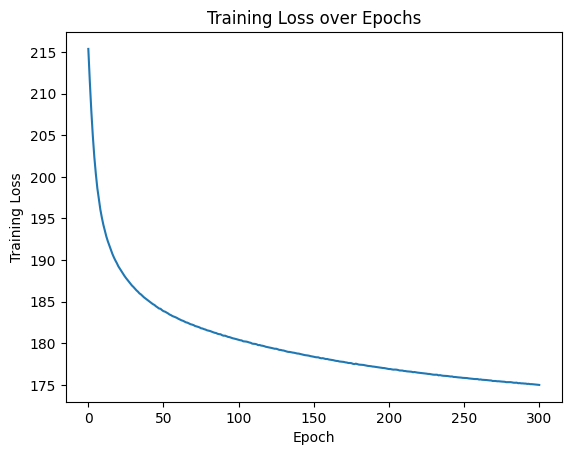

In [20]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()